In [20]:
import networkx as nx
import matplotlib.pyplot as plt

# 手动指定节点位置
pos = {
    1: (-14, 50), 2: (-10, 46), 3: (-6,42), 4: (-2, 38), 
    5: (2, 34), 6: (6, 30), 7: (12, 30), 8: (18, 30),
    9: (24, 30), 10: (30, 30), 11: (36, 30), 12: (2, 26),
    13: (6, 22), 14: (10, 18), 15: (14, 14), 16: (18, 10),
    17: (-4, 4), 18: (2, 4), 19: (8, 4), 20: (14, 4),
    21: (22, 4), 22: (28, 4), 23: (34, 4), 24: (40, 4)
}

# 添加有向边
edges = [(1, 2), (2, 3), (3, 4), (4, 5), (5, 12), (6, 12), (12, 13), (13, 14),
         (14, 15), (15, 16), (16, 20), (16, 21), (18, 17), (19, 18), (20, 19),
         (6, 5), (7, 6), (8, 7), (9, 8), (10, 9), (11, 10), (21, 20), (22, 21),
         (23, 22), (24, 23)]

def generate_bidirectional_network():
    # 创建一个有向图
    G = nx.MultiDiGraph()

    # 添加节点
    nodes = range(1, 21)
    G.add_nodes_from(nodes)

    # 添加边和反向边
    edge_labels = {}
    total_edges = len(edges)
    for i, edge in enumerate(edges, 1):
        G.add_edge(*edge, label=f'{i}')
        G.add_edge(edge[1], edge[0], label=f'{i + total_edges}')
        edge_labels[(edge[0], edge[1], 0)] = f'{i}'
        edge_labels[(edge[1], edge[0], 0)] = f'{i + total_edges}'

    # 设置节点属性
    node_labels = {node: str(node) for node in G.nodes}
    nx.set_node_attributes(G, node_labels, 'label')

    # 用双线绘制双向边的图形
    # nx.draw(G, pos, with_labels=True, labels=node_labels, node_color='lightblue',
    #         node_size=500, connectionstyle='arc3,rad=0.2', 
    #         font_size=12, font_weight='bold', edgecolors='black')

    # 为每条边手动绘制边缘标签
    for (u, v, key), label in edge_labels.items():
        x1, y1 = pos[u]
        x2, y2 = pos[v]
        if int(label) <= total_edges:
            text_x = (x1 + x2) / 2 - 0.6
            text_y = (y1 + y2) / 2 - 0.6
        else:
            text_x = (x1 + x2) / 2 + 0.6
            text_y = (y1 + y2) / 2 + 0.6
        plt.text(text_x, text_y, label, fontsize=10, color='black', ha='center', va='center')


    return G


def get_upstream(G, edge_label):
    edge_label = str(edge_label)  # 确保标签为字符串
    upstream_edges = set()
    # 先找到目标边
    target_edge = None
    for u, v, k, data in G.edges(data=True, keys=True):
        if data['label'] == edge_label:
            target_edge = (u, v, k)
            break
    
    if target_edge:
        start_node = target_edge[0]
        target_end_node = target_edge[1]
        for u, v, k, data in G.in_edges(start_node, data=True, keys=True):
            # 过滤掉与目标边有相同节点对的边
            if not (u == target_end_node and v == start_node):
                upstream_edges.add(int(data['label']))
    
    if not upstream_edges:
        upstream_edges = {-1}  # 用一个无效值替代空集合  
              
    return upstream_edges

def get_downstream(G, edge_label):
    edge_label = str(edge_label)  # 确保标签为字符串
    downstream_edges = set()
    # 先找到目标边
    target_edge = None
    for u, v, k, data in G.edges(data=True, keys=True):
        if data['label'] == edge_label:
            target_edge = (u, v, k)
            break

    if target_edge:
        end_node = target_edge[1]
        target_start_node = target_edge[0]
        for u, v, k, data in G.out_edges(end_node, data=True, keys=True):
            # 过滤掉与目标边有相同节点对的边
            if not (u == end_node and v == target_start_node):
                downstream_edges.add(int(data['label']))
    
    if not downstream_edges:
        downstream_edges = {-1}  # 用一个无效值替代空集合
    
    return downstream_edges

# 测试函数
grid_graph = generate_bidirectional_network()
# print(get_upstream(grid_graph, 3))
# print(get_downstream(grid_graph, 3))


In [21]:
import pandas as pd
import numpy as np
from glob import glob

# 定义参数a
a = 10.0

# 读取正常情况下的数据文件
normal_files = glob('F:/data/normal0605/*.txt')
normal_data = []

for file in normal_files:
    df = pd.read_csv(file, sep=';', header=None, names=['road_id', 'start_time', 'end_time', 'speed'])
    normal_data.append(df)

# 合并所有正常情况下的数据
normal_data = pd.concat(normal_data, ignore_index=True)

# 打印合并后的正常数据，检查格式和内容
# print("Normal data:")
# print(normal_data.head())

# 读取拥堵情况下的数据文件
congestion_file = 'F:/data/accident0605/0.txt'
congestion_data = pd.read_csv(congestion_file, sep=';', header=None, names=['road_id', 'start_time', 'end_time', 'speed'])

# 打印拥堵数据，检查格式和内容
# print("Congestion data:")
# print(congestion_data.head())

# 处理时间区间，将开始时间和结束时间相同的数据归为同一个时间区间
def assign_time_intervals(df):
    df['time_interval'] = df.groupby(['start_time', 'end_time']).ngroup() + 1
    return df

normal_data = assign_time_intervals(normal_data)
congestion_data = assign_time_intervals(congestion_data)

# 打印处理后的正常数据和拥堵数据，检查时间区间
# print("Processed normal data with time intervals:")
# print(normal_data.head())
# print("Processed congestion data with time intervals:")
# print(congestion_data.head())

# 计算正常情况下的平均速度和标准差
normal_stats = normal_data.groupby(['time_interval', 'road_id'])['speed'].agg(['mean', 'std']).reset_index()
normal_stats = normal_stats.rename(columns={'mean': 'v0', 'std': 'b'})

# 打印统计数据，检查是否正确
# print("Normal stats:")
# print(normal_stats.head())

# 将正常情况下的统计数据和拥堵情况下的数据合并
merged_data = pd.merge(congestion_data, normal_stats, on=['time_interval', 'road_id'], how='left')

# 判断拥堵情况
def determine_congestion(row, a):
    if row['speed'] <= row['v0'] - a * row['b']:
        return 1
    else:
        return 0

merged_data['Pmn'] = merged_data.apply(determine_congestion, axis=1, args=(a,))

# 打印合并后的数据，检查Pmn列
# print("Merged data with Pmn:")
# print(merged_data.head())

# 生成Pmn字典
Pmn = {}
for _, row in merged_data.iterrows():
    m = row['time_interval']
    n = row['road_id']
    if m not in Pmn:
        Pmn[m] = {}
    Pmn[m][n] = row['Pmn']

# 输出Pmn字典
# print("Pmn dictionary:")
print(Pmn[3][42])

# 检查具体时间区间和道路ID是否存在
# time_interval_to_check = 1  # 示例，修改为实际存在的时间区间
# road_id_to_check = 2
# if time_interval_to_check in Pmn:
#     if road_id_to_check in Pmn[time_interval_to_check]:
#         print(Pmn[time_interval_to_check][road_id_to_check])
#     else:
#         print(f"道路ID {road_id_to_check} 不存在于时间区间 {time_interval_to_check} 中。")
# else:
#     print(f"时间区间 {time_interval_to_check} 不存在。")


1.0


In [22]:
import gurobipy as gp
from gurobipy import GRB
import random

# 设置随机种子
random.seed(123)

# 创建模型
model = gp.Model("mip1")

# 定义参数N和M的值
N = 50  # 边的编号
M = 15   # 时间的编号
K = 1
M_range = range(1,M+1)
N_range = range(1,N+1)
K_range = range(1,K+1)



# 创建二维变量矩阵P，并初始化为0
P = {}
P_initial = {}  # 用于保存P的初始值
for i in M_range:
    for j in N_range:
        P[i, j] = Pmn[i][j]


# origin_time_index = 1  # 事故发生时间
# origin_link_index = 7  # 事故发生link


# P[3,17]=0
# 随机选择noise个需要转换的值的索引
noise = 5
indices = []
while len(indices) < noise:
    index = random.choice(list(P.keys()))
    if index not in indices:
        indices.append(index)

#对选定的索引进行值的转换
# for index in indices:
#     P[index] = 1 - P[index]  # 直接修改P中的值

for i in M_range:
    for j in N_range:
        P_initial[i, j] = model.addVar(vtype=GRB.BINARY, name=f"P_initial[{i},{j}]")
        P_initial[i, j].LB = float(P[i, j])
        P_initial[i, j].UB = float(P[i, j])



model.update()


In [23]:
# 创建决策变量
gamma  = model.addVars(K_range,M_range,N_range,vtype=GRB.BINARY, name="gamma") #link n在时间区间m上确实受到了事故k影响则为1
delta  = model.addVars(K_range,M_range,N_range,vtype=GRB.BINARY, name="delta") #事故k起源于在时间区间m上的link n则为1
lambda1 = model.addVars(K_range,M_range,N_range, vtype=gp.GRB.BINARY, name="lambda1")
lambda2 = model.addVars(K_range,M_range,N_range, vtype=gp.GRB.BINARY, name="lambda2")
lambda3 = model.addVars(K_range,M_range,N_range, vtype=gp.GRB.BINARY, name="lambda3")
lambda4 = model.addVar(vtype=gp.GRB.BINARY, name="lambda4")
lambda5 = model.addVar(vtype=gp.GRB.BINARY, name="lambda5")
lambda6 = model.addVar(vtype=gp.GRB.BINARY, name="lambda6")

def get_value(delta, k,m,n):
    if k in K_range and m in M_range and n in N_range:
        return delta[k,m,n]
    else:
        return 0
    
def run():
    # %%
    #     求解模型
    model.optimize()

    if model.status == GRB.OPTIMAL:
        # 获取P的取值
        P_values = model.getAttr('X', P_initial)

        # 打印P的取值
        for i in M_range:
            for j in N_range:
                if P_values[i, j] > 0:
                    print(f"P_initial[{i},{j}] = {P_values[i, j]}")

        # 获取gamma的取值
        gamma_values = model.getAttr('X', gamma)

        # 打印gamma的取值
        for k in K_range:
            for m in M_range:
                for n in N_range:
                    if gamma_values[k, m, n] > 0:
                        print(f"gamma[{k},{m},{n}] = {gamma_values[k, m, n]}")

        # 获取delta的取值
        delta_values = model.getAttr('X', delta)

        # 打印delta的取值
        for k in K_range:
            for m in M_range:
                for n in N_range:
                    if delta_values[k, m, n] > 0:
                        print(f"delta[{k},{m},{n}] = {delta_values[k, m, n]}")

           
        # 生成5个有向图，每个图对应一个时间步长
        for time_step in M_range:
            # 创建新的有向图
            G_time_step = generate_bidirectional_network()
            # 清除所有边
            # G_time_step.remove_edges_from(list(G_time_step.edges))
            # 更新边的颜色
            for k in K_range:
                for n in N_range:
                    # 检查当前时间步长下，每条边的delta值
                    if delta_values[k, time_step, n] > 0:
                        # 如果delta值为1，将边颜色设置为红色
                        # 找到对应的边
                        for edge in G_time_step.edges:
                            if G_time_step.edges[edge]['label'] == str(n):  # 确保 n 是字符串类型
                                G_time_step.edges[edge]['color'] = 'red'

            # 绘制更新后的图形
            edge_colors = nx.get_edge_attributes(G_time_step, 'color')
            edge_colors_list = [edge_colors.get(edge, 'black') for edge in G_time_step.edges]

            nx.draw(G_time_step, pos, with_labels=True, node_color='lightblue',
                    node_size=500, arrowstyle='->', arrowsize=10,
                    font_size=12, font_weight='bold', edge_color=edge_colors_list,
                    connectionstyle='arc3,rad=0.4')  # 使用弧线来表示边

            # 添加标题，指示当前时间步长
            plt.title(f"Time {time_step}")
            # 显示图形
            plt.show()



In [24]:
#目标函数
model.setObjective(gp.quicksum(P_initial[m,n]*(1-gp.quicksum(delta[k,m,n]for k in K_range))+(1-P_initial[m,n])*gp.quicksum(delta[k,m,n]for k in K_range)for m in M_range for n in N_range), GRB.MINIMIZE)


In [25]:
# model.addConstr(delta[1, 2, 17] == 1)
# model.addConstr(delta[1, 3, 7] == 1)
# model.addConstr(gamma[1, 1, 7] == 1)

In [26]:
# for k in K_range:
#     for m in M_range:
#         for n in N_range:
#             if k in K_range and m in M_range and n in N_range:
#                 model.addConstr(gp.quicksum(get_delta_value(k,m,l) for l in get_downstream(grid_graph, n)) +get_delta_value(k,m-1,n) >= delta[k,m,n] - gamma[k,m,n], name="c1")

In [27]:
#约束1-2 保证冲击波的定向传播
#约束1：如果cell<m,n>受到了事故影响，且不是起源cell，那么该影响势必源自下游link或前一时刻或二者兼具
model.addConstrs((gp.quicksum(get_value(delta,k,m,l)for l in get_downstream(grid_graph, n))+get_value(delta,k,m-1,n)>=delta[k,m,n]-gamma[k,m,n] for k in K_range for m in M_range for n in N_range), "c1")

{(1, 1, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 2): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 3): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 4): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 5): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 6): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 7): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 8): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 9): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 10): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 11): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 12): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 13): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 14): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 15): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 16): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 17): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 18): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 19): <gurobi.Constr *Awaiting

In [28]:
#约束3-6 保证冲击波的不间断传播
#约束3：
model.addConstrs((get_value(delta, k,m-1,n) <= get_value(lambda1, k, m-1, n) for k in K_range for m in M_range for n in N_range),"c3")
#约束4：
model.addConstrs((gp.quicksum(get_value(delta,k,m,l)for l in get_downstream(grid_graph, n)) <= lambda2[k, m, n]*len(get_downstream(grid_graph, n)) for k in K_range for m in M_range for n in N_range),"c4")
#约束5:)
model.addConstrs((delta[k,m,n] >= 1 - lambda3[k,m,n] for k in K_range for m in M_range for n in N_range),"c5")
#约束6:
model.addConstrs((get_value(lambda1, k, m-1, n) + lambda2[k, m, n] + lambda3[k, m, n] <= 2 for k in K_range for m in M_range for n in N_range),"c6")

{(1, 1, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 2): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 3): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 4): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 5): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 6): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 7): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 8): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 9): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 10): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 11): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 12): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 13): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 14): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 15): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 16): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 17): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 18): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 19): <gurobi.Constr *Awaiting

In [29]:
#约束7-10 当某一link受到事故影响，且该link的上游link也受到了事故影响，那么该link的其余上游link中，车道累计车辆数大于被影响的上游link的，也都应该被事故影响了
#约束7:
# m.addConstrs((gp.quicksum(delta[k,m,l]for l in range(get_upstream(grid_graph, n)))<=lambda4*len(get_upstream(grid_graph, n)) for k in K_range for m in M_range for n in N_range), "c7")
#约束8:


In [30]:
#约束11：针对每一起事故，有且仅有一个cell是事故的起源点
model.addConstrs((gp.quicksum(gamma[k,m,n]for m in M_range for n in N_range) == 1 for k in K_range), "c11")

{1: <gurobi.Constr *Awaiting Model Update*>}

In [31]:
#约束12：如果cell<m,n>是起源点(终止点)，那么其必会受到事故的影响
model.addConstrs((gamma[k,m,n] <= delta[k,m,n]for k in K_range for m in M_range for n in N_range), "c12")

{(1, 1, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 2): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 3): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 4): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 5): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 6): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 7): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 8): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 9): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 10): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 11): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 12): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 13): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 14): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 15): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 16): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 17): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 18): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 19): <gurobi.Constr *Awaiting

In [32]:
#约束13-14 当cell<m,n>是起源点时，前一时刻与上游路段集合的cell都不会受到事故影响
#约束13：
model.addConstrs((gp.quicksum(get_value(delta,k,m,l)for l in get_downstream(grid_graph, n))<=(1-gamma[k,m,n])*len(get_downstream(grid_graph, n))for k in K_range for m in M_range for n in N_range), "c13")
#约束14：
model.addConstrs((1-gamma[k,m,n] >= get_value(delta, k,m-1,n)for k in K_range for m in M_range for n in N_range), "c14")
#约束15:反之亦然
model.addConstrs((gp.quicksum(get_value(delta,k,m,l)for l in get_downstream(grid_graph, n))+get_value(delta, k,m-1,n)>=delta[k,m,n]-gamma[k,m,n]for k in K_range for m in M_range for n in N_range), "c15")

{(1, 1, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 2): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 3): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 4): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 5): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 6): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 7): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 8): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 9): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 10): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 11): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 12): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 13): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 14): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 15): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 16): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 17): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 18): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 19): <gurobi.Constr *Awaiting

In [33]:
#约束16：针对每一个cell，其产生的拥堵影响只会归属于一起事故
model.addConstrs((gp.quicksum(delta[k,m,n]for k in K_range)<=1 for m in M_range for n in N_range), "c16")

{(1, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 2): <gurobi.Constr *Awaiting Model Update*>,
 (1, 3): <gurobi.Constr *Awaiting Model Update*>,
 (1, 4): <gurobi.Constr *Awaiting Model Update*>,
 (1, 5): <gurobi.Constr *Awaiting Model Update*>,
 (1, 6): <gurobi.Constr *Awaiting Model Update*>,
 (1, 7): <gurobi.Constr *Awaiting Model Update*>,
 (1, 8): <gurobi.Constr *Awaiting Model Update*>,
 (1, 9): <gurobi.Constr *Awaiting Model Update*>,
 (1, 10): <gurobi.Constr *Awaiting Model Update*>,
 (1, 11): <gurobi.Constr *Awaiting Model Update*>,
 (1, 12): <gurobi.Constr *Awaiting Model Update*>,
 (1, 13): <gurobi.Constr *Awaiting Model Update*>,
 (1, 14): <gurobi.Constr *Awaiting Model Update*>,
 (1, 15): <gurobi.Constr *Awaiting Model Update*>,
 (1, 16): <gurobi.Constr *Awaiting Model Update*>,
 (1, 17): <gurobi.Constr *Awaiting Model Update*>,
 (1, 18): <gurobi.Constr *Awaiting Model Update*>,
 (1, 19): <gurobi.Constr *Awaiting Model Update*>,
 (1, 20): <gurobi.Constr *Awaiting Model

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 7501 rows, 4503 columns and 19290 nonzeros
Model fingerprint: 0xf65a4ba4
Model has 750 quadratic objective terms
Variable types: 0 continuous, 4503 integer (4503 binary)
Coefficient statistics:


  Matrix range     [1e+00, 2e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [4e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+00]
Found heuristic solution: objective 103.0000000
Presolve removed 4379 rows and 2755 columns
Presolve time: 0.07s
Presolved: 3122 rows, 1748 columns, 10438 nonzeros
Variable types: 0 continuous, 1748 integer (1748 binary)

Root relaxation: objective 1.170833e+01, 137 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   11.70833    0   39  103.00000   11.70833  88.6%     -    0s
     0     0   16.72619    0   67  103.00000   16.72619  83.8%     -    0s
H    0     0                      48.0000000   16.72619  65.2%     -    0s
     0     0   19.46298    0   69   48.00000   19.46298  59.5%     -    0s
     0     0   19.74286    0   68   48.00000   19.74286  58.9%     -

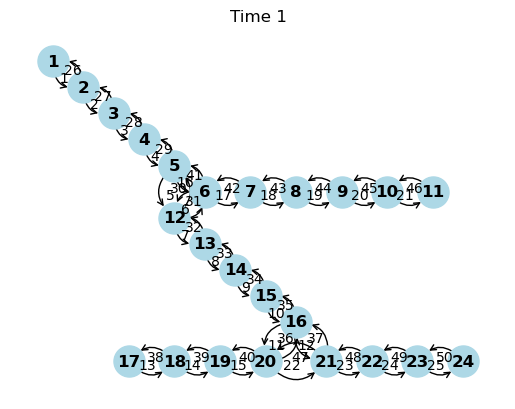

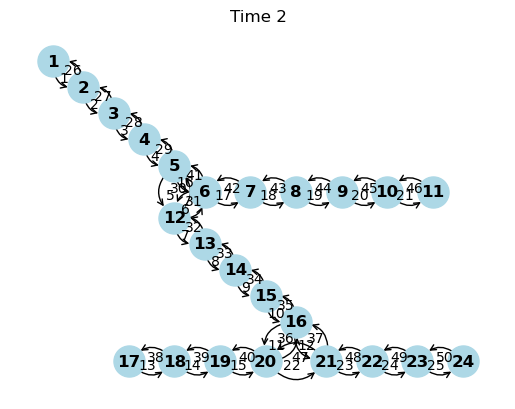

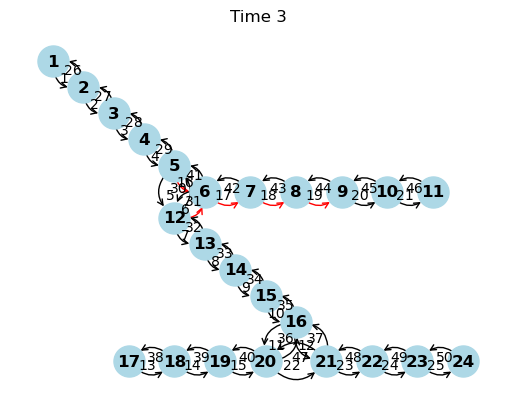

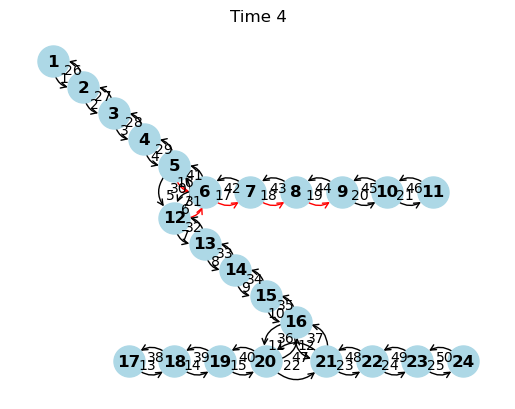

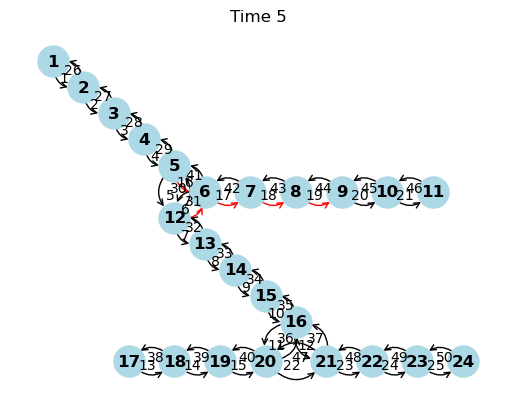

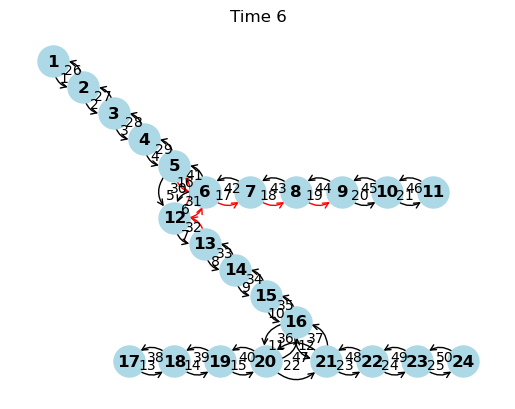

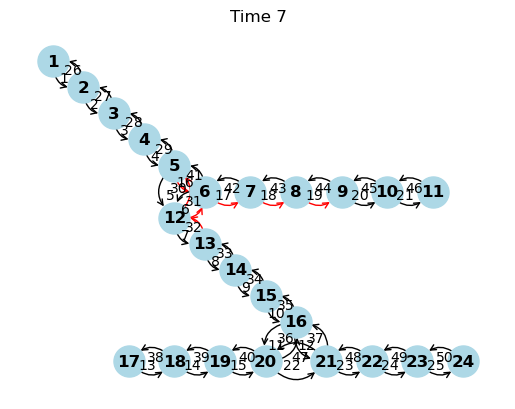

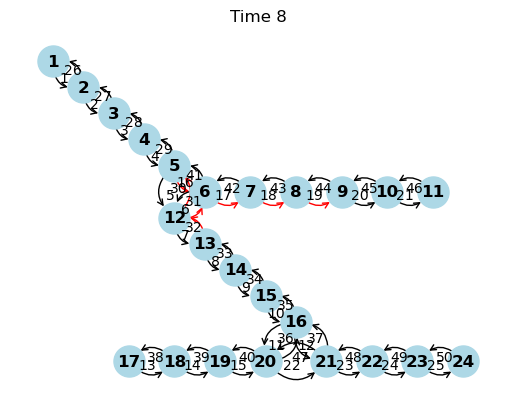

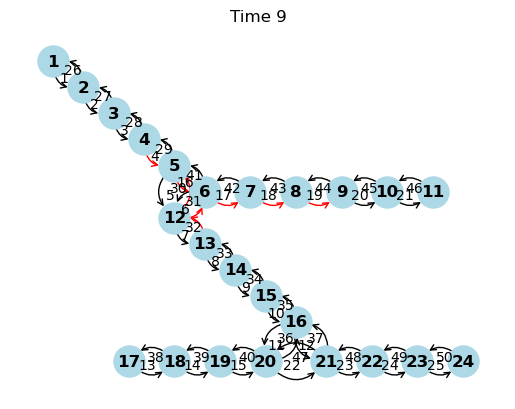

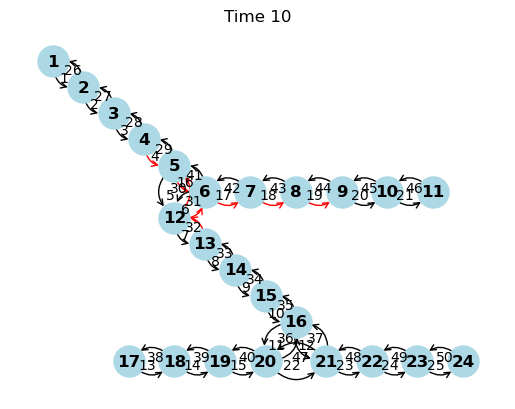

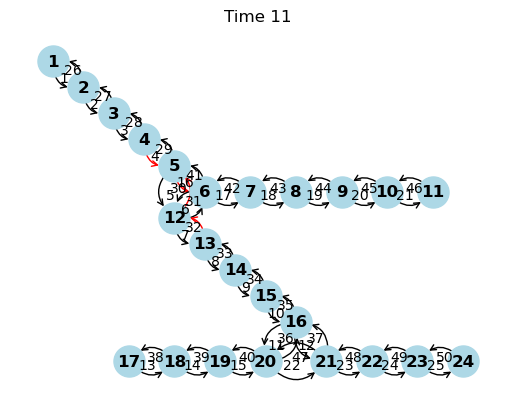

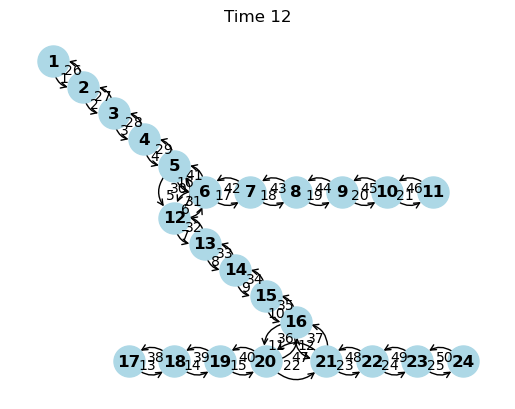

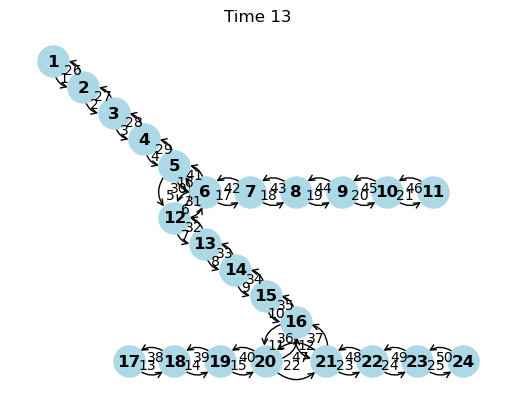

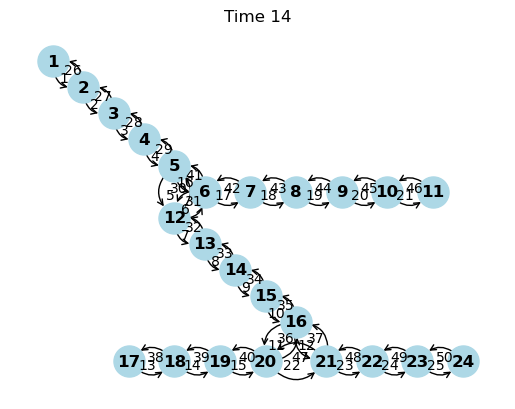

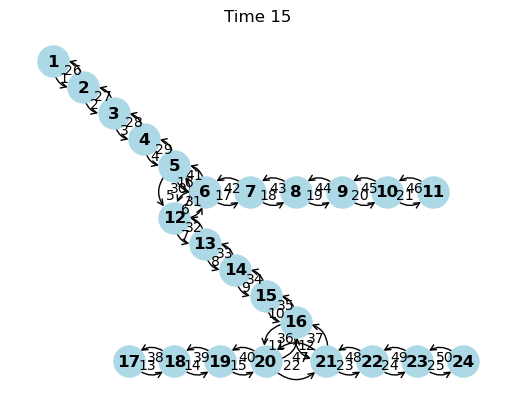

In [34]:
# 求解模型
run()




